# Optimising synaptic parameters in Arbor

This notebook shows how the parameters of an Arbor point process (in this case a synapse), can be optimised using BluePyOpt.

First some initial setup:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
%reload_ext autoreload
%autoreload

import os

import bluepyopt as bpopt
import bluepyopt.ephys as ephys

We need a Simulator (NEURON), Morphology (one compartment) and two Location objects (the 'somatic' sectionlist and the center of the soma).

In [2]:
# Arbor simulator
arb_sim = ephys.simulators.ArbSimulator()

# Single compartment
morph = ephys.morphologies.NrnFileMorphology('simple.swc')

# Object that points to sectionlist somatic
somatic_loc = ephys.locations.NrnSeclistLocation('somatic',seclist_name='somatic')

# Object that points to the center of the soma
somacenter_loc = ephys.locations.ArbBranchRelLocation(
    name='somacenter',
    branch=0,
    pos=0.5)

We will also add a leak channel:

In [3]:
pas_mech = ephys.mechanisms.NrnMODMechanism(                                    
    name='pas',                                                                 
    suffix='pas',                                                               
    locations=[somatic_loc])                                                    

Now comes the code which will add the synapse. We specify the suffix of the point process MOD file, and the location (or the list of locations) where to add it.

In [4]:
# Add ExpSyn synapse pointprocess at the center of the soma
expsyn_mech = ephys.mechanisms.NrnMODPointProcessMechanism(                     
    name='expsyn',                                                              
    suffix='ExpSyn',                                                            
    locations=[somacenter_loc])                                                 

Once we have defined a point process, we can create a Location object that points to it

In [5]:
expsyn_loc = ephys.locations.NrnPointProcessLocation(                           
    'expsyn_loc',                                                               
    pprocess_mech=expsyn_mech)                                                  

Using this location, we can specify the parameters of the synapse. Let's fit the decay time constant:

In [6]:
expsyn_tau_param = ephys.parameters.NrnPointProcessParameter(                   
    name='expsyn_tau',                                                          
    param_name='tau',                                                           
    value=2,                                                                    
    bounds=[0, 50],                                                             
    locations=[expsyn_loc])

Let's put all these concepts together in a cell model:

In [7]:
cell = ephys.models.CellModel(                                               
    name='simple_cell',                                                      
    morph=morph,                                                             
    mechs=[pas_mech, expsyn_mech],                                           
    params=[expsyn_tau_param])                                     

Now we need to define the fitness function. The idea is to stimulate the synapse 5 times, and let the resulting train of EPSPs reach exactly -50 mV.

We first create a stimulus that injects the presynaptic events:

In [8]:
stim_start = 20
number = 5
interval = 5

netstim = ephys.stimuli.NrnNetStimStimulus(                                  
    total_duration=200,                                                      
    number=5,                                                                
    interval=5,                                                              
    start=stim_start,                                                        
    weight=5e-4,                                                             
    locations=[expsyn_loc])

stim_end = stim_start + interval * number

rec = ephys.recordings.CompRecording(
    name='soma.v', 
    location=somacenter_loc,
    variable='v')

protocol = ephys.protocols.ArbSweepProtocol('netstim_protocol', [netstim], [rec])

Then we define an eFELFeature that will target the maximum voltage and we put everything in an evaluator

In [9]:
max_volt_feature = ephys.efeatures.eFELFeature(                              
    'maximum_voltage',                                                       
    efel_feature_name='maximum_voltage',                                     
    recording_names={'': 'soma.v'},                                          
    stim_start=stim_start,                                                   
    stim_end=stim_end,                                                       
    exp_mean=-50,                                                            
    exp_std=.1)

max_volt_objective = ephys.objectives.SingletonObjective(                    
    max_volt_feature.name,                                                   
    max_volt_feature)                       

score_calc = ephys.objectivescalculators.ObjectivesCalculator(               
    [max_volt_objective])                                                    

cell_evaluator = ephys.evaluators.CellEvaluator(                             
    cell_model=cell,                                                         
    param_names=['expsyn_tau'],                                              
    fitness_protocols={protocol.name: protocol},                             
    fitness_calculator=score_calc,                                           
    sim=arb_sim)                                                             

Let's try out the evaluator with a decay time constant of 10.0

In [10]:
default_param_values = {'expsyn_tau': 10.0}                                  

print(cell_evaluator.evaluate_with_dicts(default_param_values))              

{'maximum_voltage': 497.76464958177615}


Now we can run the optimisation:

In [11]:
optimisation = bpopt.optimisations.DEAPOptimisation(                         
    evaluator=cell_evaluator,                                                
    offspring_size=10)                                                       

_, hall_of_fame, _, _ = optimisation.run(max_ngen=5)                         

And then we can plot the best individual:

Best individual:  [0.331650919141091]
Fitness values:  (5.578722836445564,)


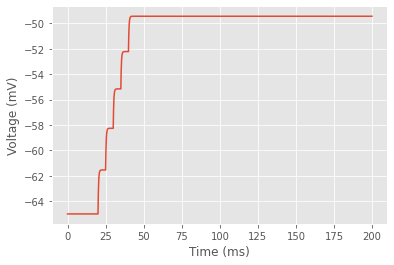

In [12]:
best_ind = hall_of_fame[0]                                                   

print('Best individual: ', best_ind)
print('Fitness values: ', best_ind.fitness.values)

best_ind_dict = cell_evaluator.param_dict(best_ind)                          
responses = protocol.run(                                                    
    cell_model=cell,                                                         
    param_values=best_ind_dict,                                              
    sim=arb_sim)                                                             

time = responses['soma.v']['time']                                           
voltage = responses['soma.v']['voltage']                                     

import matplotlib.pyplot as plt                                              
plt.style.use('ggplot')                                                      
plt.plot(time, voltage)                                                      
plt.xlabel('Time (ms)')                                                      
plt.ylabel('Voltage (mV)')                                                   
plt.show()                                                                   